In [1]:
import torch
from torch import nn
from src.modules.decoder_2 import Model
from src.modules.dataset import FlickrDataset, Collate
from torch.utils.data import DataLoader
from tqdm import tqdm
import plotly.express as px
import plotly.io as pio
import torchvision.transforms as T

pio.renderers.default = 'png'

In [2]:
batch_size = 8
imgs_path = '/mnt/s/CV/data/Images'
captions_path = '/mnt/s/CV/data/captions.txt'
dataset = FlickrDataset(imgs_path, captions_path)
collate = Collate(pad_idx=dataset.vocab.word2idx['<PAD>'])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
vocab_size = len(dataset.vocab)
vocab = dataset.vocab

In [3]:
decoder_config = dict(
    vocab_size=vocab_size,
    d_model=512,
    num_heads=8
)
model = Model(**decoder_config).cuda()


In [4]:
img_batch, cap_batch = next(iter(dataloader))
img_batch = img_batch.cuda()
cap_batch = cap_batch.cuda()
preds = model(img_batch, cap_batch, None)
preds.shape

torch.Size([8, 22, 4111])

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = T.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)

In [6]:
preds = model.predict(img_batch[0])
preds = [vocab.idx2word[idx] for idx in preds]
# preds

Epoch: 1


100%|██████████| 5057/5057 [09:46<00:00,  8.63it/s]


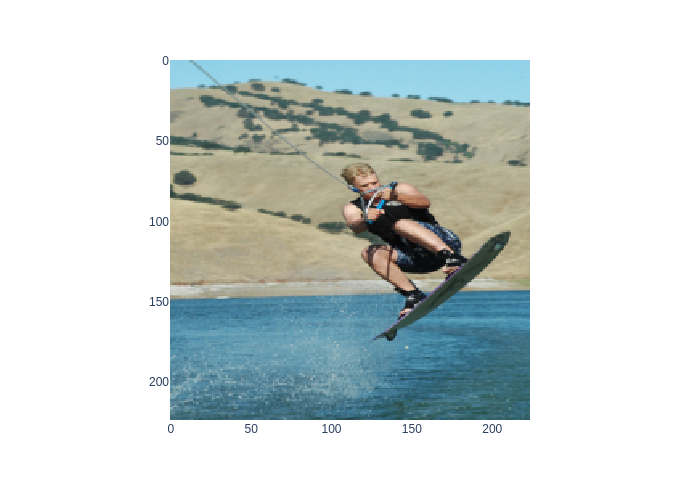

<SOS> a man is climbing up a rock . <EOS>
Loss: 3.714

Epoch: 2


100%|██████████| 5057/5057 [09:28<00:00,  8.89it/s]


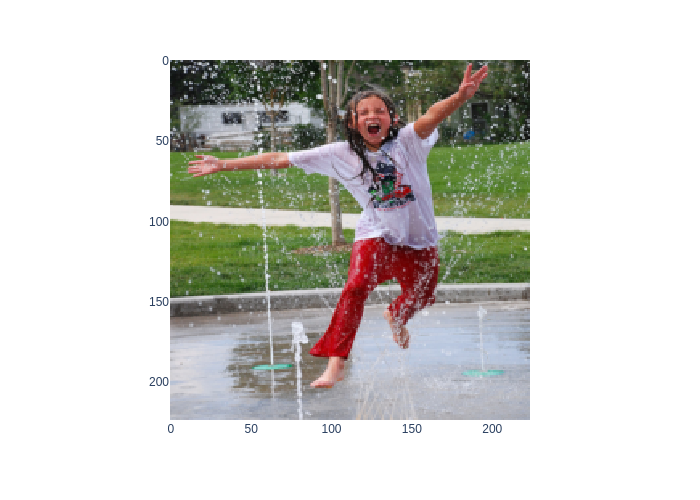

<SOS> a young boy is playing in a water fountain . <EOS>
Loss: 3.115

Epoch: 3


100%|██████████| 5057/5057 [09:26<00:00,  8.92it/s]


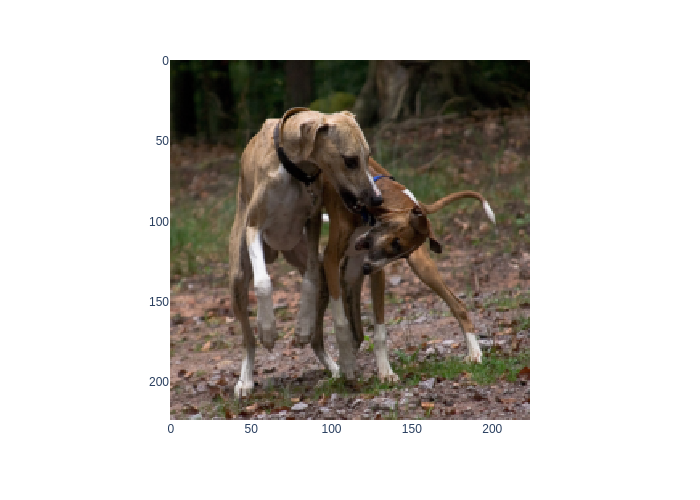

<SOS> two brown dogs are playing in the grass . <EOS>
Loss: 2.488



In [7]:
lr = 1e-4
num_epochs = 3
optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=lr
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>']).cuda()

for epoch in range(1, num_epochs+1):
    print(f'Epoch: {epoch}')
    for i, (imgs, captions) in enumerate(tqdm(dataloader), start=1):
        imgs = imgs.cuda()
        captions: torch.Tensor = captions.cuda()
        captions_input = captions[:, :-1]
        captions_expected = captions[:, 1:]
        sequence_length = captions_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).cuda()
        optimizer.zero_grad()
        outputs: torch.Tensor = model(
            imgs,
            captions_input,
            tgt_mask=tgt_mask
        )
        loss: torch.Tensor = criterion(
            outputs.contiguous().view(-1, vocab_size),
            captions_expected.contiguous().view(-1)
        )
        loss.backward()
        optimizer.step()
        # if i % 200 == 0:
    px.imshow(inv_normalize(imgs[0].cpu()).permute(1, 2, 0)).show()
    preds = model.predict(imgs[0])
    preds = [vocab.idx2word[idx] for idx in preds]
    print(' '.join(preds))
    print('Loss:', round(loss.item(), 3))
    print()

torch.save(model.state_dict(), 'weights_transformer.pt')

In [8]:
model.load_state_dict(torch.load('weights_transformer.pt'))

<All keys matched successfully>

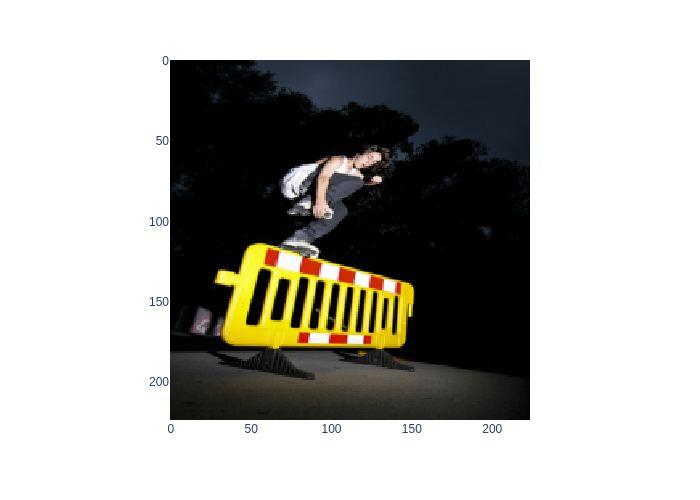

'<SOS> a man in a black shirt is skateboarding on a ramp . <EOS>'

In [37]:
img_batch, cap_batch = next(iter(dataloader))
img = img_batch[0].cuda()
cap = cap_batch[0].cuda()
idx = 1
px.imshow(inv_normalize(img.cpu()).permute(1, 2, 0)).show()
' '.join([vocab.idx2word[idx] for idx in model.predict(img)])